In [54]:
import pandas as pd
import numpy as np
import keras
from keras.layers import Dense, Dropout, Activation, Input, Permute, multiply, Flatten, GlobalAveragePooling1D
from sklearn.preprocessing import StandardScaler
from keras import optimizers
from keras.layers.recurrent import LSTM
from keras.models import Model 
import matplotlib.pyplot as plt
from keras_self_attention import SeqSelfAttention
%matplotlib inline

In [2]:
df = pd.read_csv("000002-from-1995-01-01.csv")
print(df.shape)
df.head()

(5185, 6)


,open,high,low,volume,amount,close
0,20.64,20.64,20.37,16362363.0,3.350027e+08,20.56
1,20.92,20.92,20.60,21850597.0,4.520071e+08,20.64
2,21.00,21.15,20.72,26910139.0,5.628396e+08,20.94
3,20.70,21.57,20.70,64585536.0,1.363421e+09,21.02
4,20.60,20.70,20.20,45886018.0,9.382043e+08,20.70


In [7]:
df[df.columns] = StandardScaler().fit_transform(df[df.columns].values)

In [8]:
def reshape_data(df):
    ref_days = 20
    predict_day = 1
    split_ratio = 0.8
    split_index = round(df.shape[0] * split_ratio)
    shaped_x = []
    shaped_y = []
    for i in range(df.shape[0] - ref_days - predict_day):       
        shaped_x.append(np.array(df.iloc[i:i+ref_days, :-1]))
        shaped_y.append(np.array(df.iloc[i+ref_days:i+ref_days+predict_day,-1]))
    
    shaped_x = np.array(shaped_x)
    shaped_y = np.array(shaped_y)
    
    x_tain = shaped_x[:split_index]
    x_test = shaped_x[split_index:]
    y_train = shaped_y[:split_index]
    y_test = shaped_y[split_index:]
    
    return x_tain, x_test, y_train, y_test

In [9]:
x_train, x_test, y_train, y_test = reshape_data(df)

In [10]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((4148, 20, 5), (1016, 20, 5), (4148, 1), (1016, 1))

In [11]:
def attention_block(inputs):   
    a = Permute((2,1))(inputs)   
    a = Dense(20, activation="softmax")(a)  
    a_prob = Permute((2,1))(a)   
    return multiply([inputs, a_prob])

In [55]:
inputs = Input(shape=(x_train.shape[1:]))
x = LSTM(5, 
         return_sequences=True
        )(inputs)
print(x.get_shape())
# x = attention_block(x)
x = SeqSelfAttention()(x)
# x = Flatten()(x)
x = GlobalAveragePooling1D()(x)
print(x.get_shape())
x = Dense(1)(x)
model = Model(inputs=inputs, outputs=x)
model.compile(loss="mse", 
              optimizer=optimizers.Adam(lr=1e-4, clipnorm=1.), 
              metrics=['mse'])

(?, ?, 5)
(?, 5)


In [56]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 20, 5)             0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 20, 5)             220       
_________________________________________________________________
seq_self_attention_11 (SeqSe (None, 20, 5)             385       
_________________________________________________________________
global_average_pooling1d_1 ( (None, 5)                 0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 6         
Total params: 611
Trainable params: 611
Non-trainable params: 0
_________________________________________________________________


In [57]:
model_history = model.fit(x_train, y_train,
                          batch_size=32,
                          epochs=50,
                          verbose=1,
                          validation_data=(x_test, y_test))

Train on 4148 samples, validate on 1016 samples
Epoch 1/50
4148/4148 [==============================] - 6s 1ms/step - loss: 1.6279 - mean_squared_error: 1.6279 - val_loss: 1.5578 - val_mean_squared_error: 1.5578
Epoch 2/50
4148/4148 [==============================] - 6s 1ms/step - loss: 1.4240 - mean_squared_error: 1.4240 - val_loss: 1.3830 - val_mean_squared_error: 1.3830
Epoch 3/50
4148/4148 [==============================] - 6s 1ms/step - loss: 1.2383 - mean_squared_error: 1.2383 - val_loss: 1.2106 - val_mean_squared_error: 1.2106
Epoch 4/50
4148/4148 [==============================] - 6s 1ms/step - loss: 1.0774 - mean_squared_error: 1.0774 - val_loss: 1.0472 - val_mean_squared_error: 1.0472
Epoch 5/50
4148/4148 [==============================] - 6s 1ms/step - loss: 0.9426 - mean_squared_error: 0.9426 - val_loss: 0.9007 - val_mean_squared_error: 0.9007
Epoch 6/50
4148/4148 [==============================] - 6s 1ms/step - loss: 0.8304 - mean_squared_error: 0.8304 - val_loss: 0.7717 -

In [19]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])

1016/1016 [==============================] - 0s 356us/step
Test loss: 0.0246071887292


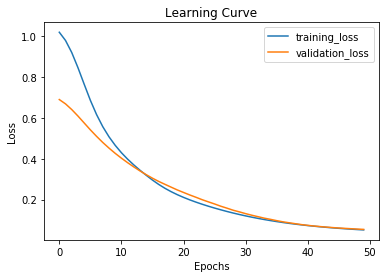

In [19]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

In [21]:
# pred_raw = model.predict(x_test)

In [28]:
# pred_attention1 = model.predict(x_test)

In [52]:
# pred_attention2 = model.predict(x_test)

In [58]:
pred_attention_gl = model.predict(x_test)

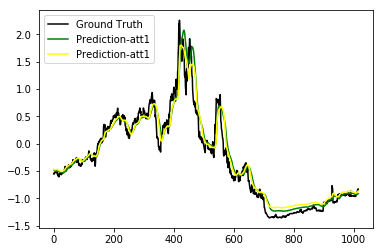

In [60]:
plt.plot(y_test, color='black', label='Ground Truth')
# plt.plot(pred_raw, color='blue', label='Prediction')
# plt.plot(pred_attention1, color='red', label='Prediction-att1')
plt.plot(pred_attention2, color='green', label='Prediction-att1')
plt.plot(pred_attention_gl, color='yellow', label='Prediction-att1')
plt.legend(loc='upper left')
plt.show()